# Assignmen8_part2

## Ozone Data

In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
#import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline

In [5]:
df_airquality = pd.read_csv('airquality.csv',usecols = ['Ozone','Solar.R','Wind','Temp'])
df_airquality.head()


,Ozone,Solar.R,Wind,Temp
0,41.0,190.0,7.4,67
1,36.0,118.0,8.0,72
2,12.0,149.0,12.6,74
3,18.0,313.0,11.5,62
4,NaN,NaN,14.3,56


In [6]:
df_airquality['TWcp'] = np.round(df_airquality['Temp']* df_airquality['Wind'],2)
df_airquality['TWrat'] = np.round(df_airquality['Temp']/ df_airquality['Wind'],2)

df_airquality = df_airquality.dropna()

print(df_airquality.isna().any())
# print(df_airquality.head())

df_airquality['CV'] = np.random.randint(low= 0, high= 10, size =(df_airquality.shape[0],))
print(df_airquality)

print('\n\n Value Counts of Integers for Manual cross validation:\n',df_airquality.CV.value_counts().sort_index())

Ozone      False
Solar.R    False
Wind       False
Temp       False
TWcp       False
TWrat      False
dtype: bool
     Ozone  Solar.R  Wind  Temp    TWcp  TWrat  CV
0     41.0    190.0   7.4    67   495.8   9.05   5
1     36.0    118.0   8.0    72   576.0   9.00   0
2     12.0    149.0  12.6    74   932.4   5.87   4
3     18.0    313.0  11.5    62   713.0   5.39   1
6     23.0    299.0   8.6    65   559.0   7.56   4
..     ...      ...   ...   ...     ...    ...  ..
147   14.0     20.0  16.6    63  1045.8   3.80   3
148   30.0    193.0   6.9    70   483.0  10.14   3
150   14.0    191.0  14.3    75  1072.5   5.24   9
151   18.0    131.0   8.0    76   608.0   9.50   7
152   20.0    223.0  11.5    68   782.0   5.91   7

[111 rows x 7 columns]


 Value Counts of Integers for Manual cross validation:
 0    11
1    13
2     8
3    11
4    12
5    13
6     8
7    13
8    12
9    10
Name: CV, dtype: int64


In [7]:
PLS_Number_of_Comp =[]
MSPE_PLS = []

Ridge_MSPE = []
LASSO_MSPE = []
LASSO_NFeat = []
PCR_MSPE = []
PCR_NCopm = []

for i in range(10):
    df_train = df_airquality[df_airquality.CV != i]
    df_test = df_airquality[df_airquality.CV == i]
    
#     df_train.reset_index(inplace= True)
#     df_test.reset_index(inplace= True)
    
    X_train = df_train.drop(['Ozone', 'CV'] ,axis=1)
    y_train = df_train['Ozone']
    
    X_test =  df_test.drop(['Ozone', 'CV'],axis=1)
    y_test = df_test['Ozone']
        
    std_scale = StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std  = std_scale.transform(X_test)
    
    CV10 = RepeatedKFold(n_splits= 10, n_repeats= 1, random_state=1)
    
    # Ridge
    LMRidgeCV = RidgeCV(alphas=np.arange(0.5, 2, 0.01), cv=CV10, scoring='neg_mean_squared_error')
    LMRidgeCV.fit(X_train_std, y_train)
    LMRidge = Ridge(alpha = LMRidgeCV.alpha_)
    LMRidge.fit(X_train_std, y_train)
    Ridge_MSPE.append(mean_squared_error(y_test, LMRidge.predict(X_test_std)))
    
    #Lasso
    LMLassoCV = LassoCV(alphas = np.arange(0.5, 2, 0.01), cv = CV10, max_iter = 1000)
    LMLassoCV.fit(X_train_std, y_train)
    LMLasso = Lasso(max_iter = 10000)
    LMLasso.set_params(alpha=LMLassoCV.alpha_)
    LMLasso.fit(X_train_std, y_train)
    LASSO_MSPE.append(mean_squared_error(y_test, LMLasso.predict(X_test_std)))
    LASSO_NFeat.append(len(LMLasso.coef_) - sum(LMLasso.coef_ == 0))
    
    # PCR
    pca = PCA()
    LModel = linear_model.LinearRegression()
    for pcr_train_index, pcr_test_index in CV10.split(X_train_std):
        pcr_X_train, pcr_X_test = X_train_std[pcr_train_index], X_train_std[pcr_test_index]
        pcr_y_train, pcr_y_test = y_train.iloc[pcr_train_index], y_train.iloc[pcr_test_index]
        
        PCs_train = pca.fit_transform(pcr_X_train)
        PCs_test = pca.transform(pcr_X_test)
        PCR_MSPE_train = []
        
        for j in range(1, 5):
            LModel.fit(PCs_train[:,:j], pcr_y_train)
            PCR_MSPE_train.append(mean_squared_error(pcr_y_test, LModel.predict(PCs_test[:,:j])))

    PCR_NCopm.append(np.argmin(PCR_MSPE_train) + 1)

    PCs_train = pca.fit_transform(X_train_std)
    PCs_test = pca.transform(X_test_std)

    LModel.fit(PCs_train[:,:PCR_NCopm[i]], y_train)
    PCR_MSPE.append(mean_squared_error(y_test, LModel.predict(PCs_test[:,:PCR_NCopm[i]])))



    for pls_train_index, pls_test_index in CV10.split(X_train_std): 

        X_train_pls, X_test_pls = X_train_std[pls_train_index], X_train_std[pls_test_index]
        y_train_pls, y_test_pls = y_train.iloc[pls_train_index], y_train.iloc[pls_test_index]
        MSPE_train = []
        
        for m in range(1, 5):
            plsr = PLSRegression(n_components= m, scale=False)
            plsr.fit(X_train_pls, y_train_pls)
            MSPE_train.append(mean_squared_error(y_test_pls, plsr.predict(X_test_pls)))
        
    PLS_Number_of_Comp.append(np.argmin(MSPE_train) + 1)
    plsr = PLSRegression(n_components=PLS_Number_of_Comp[i], scale=False)
    
    plsr.fit(X_train_std, y_train)
    MSPE_PLS.append(mean_squared_error(y_test, plsr.predict(X_test_std)))

# print('MSPE_PLS', np.round(MSPE_PLS, 2))                                                                             
# print('\n\nPLS Number of Components:', PLS_Number_of_Comp)

# print('\n\nPCA Number of Components:', PCR_NCopm)


print("Ridge_MSPE: ",Ridge_MSPE,"\n\n")
print("LASSO_MSPE: ",LASSO_MSPE,"\n\n")
print("LASSO_NFeat: ",LASSO_NFeat,"\n\n")
print("PCR_MSPE: ",PCR_MSPE,"\n\n")
print("PCR_NCopm: ",PCR_NCopm,"\n\n")

print("MSPE_PLS: ",MSPE_PLS,"\n\n")
print("PLS_Number_of_Comp: ",PLS_Number_of_Comp)

Ridge_MSPE:  [272.12249497449005, 365.3761958858161, 616.2533234105116, 331.3925263729171, 308.221476772703, 385.5673644931357, 207.0781492245225, 537.8591648101213, 866.6278077018219, 410.83575693795467] 


LASSO_MSPE:  [275.35853778759025, 392.5729149174421, 630.6096255985573, 328.1519369867405, 321.16291521454656, 374.43307760769983, 204.11162049968843, 515.4143188651221, 807.3899315149029, 406.4035027912551] 


LASSO_NFeat:  [4, 4, 3, 4, 4, 4, 4, 3, 4, 4] 


PCR_MSPE:  [320.8299642009357, 642.9294416410002, 453.1969777591637, 340.01777041408525, 318.7936049554342, 393.8226099105107, 212.24175344633315, 336.2444978551917, 1011.3182042023521, 533.8118801986841] 


PCR_NCopm:  [1, 1, 2, 4, 2, 4, 4, 2, 1, 1] 


MSPE_PLS:  [279.3212586192979, 509.999472284401, 498.76299994411545, 336.1680893007437, 320.50400955349755, 432.63584160195455, 210.51233571201044, 462.59544511607663, 725.536541811181, 482.7485581814576] 


PLS_Number_of_Comp:  [1, 1, 1, 4, 2, 1, 4, 1, 4, 1]


## RMSPEs  boxplots:

RMSPE average for Ridge:  2.077155062806899
RMSPE average for LASSO:  2.0849417447989156
RMSPE average for PCR:  2.150004243032948
RMSPE average for PLS:  2.023057004103992


[Text(1, 0, 'Ridge'),
 Text(2, 0, 'LASSO'),
 Text(3, 0, 'PCR'),
 Text(4, 0, 'PLS')]

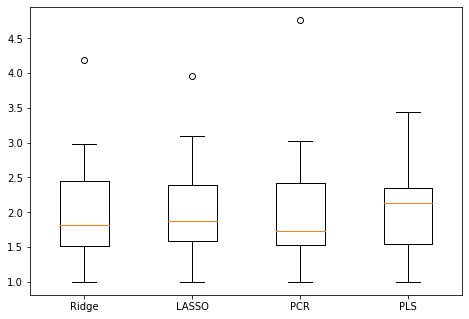

In [8]:
RMSPE_Ridge = Ridge_MSPE / min(Ridge_MSPE)
RMSPE_LASSO = LASSO_MSPE / min(LASSO_MSPE)
RMSPE_PCR = PCR_MSPE / min(PCR_MSPE)
RMSPE_PLS = MSPE_PLS / min(MSPE_PLS)

print('RMSPE average for Ridge: ', np.mean(RMSPE_Ridge))
print('RMSPE average for LASSO: ', np.mean(RMSPE_LASSO))
print('RMSPE average for PCR: ', np.mean(RMSPE_PCR))
print('RMSPE average for PLS: ', np.mean(RMSPE_PLS))

RMSPEs = [RMSPE_Ridge, RMSPE_LASSO, RMSPE_PCR, RMSPE_PLS]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.boxplot(RMSPEs)
ax.set_xticklabels(['Ridge','LASSO','PCR', 'PLS'])